In [1]:
import cv2
import sys
sys.path.append("../")
import anchors
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
%matplotlib notebook

In [2]:
def get_img_bbox(im_file, box_file):
    img_orig = cv2.imread(im_file)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    file = open(box_file, "r")
    boxes = []
#     boxes_norm = []
    h, w = img_orig.shape[0:2]
    for line in tuple(file)[2:]: 
        box = [int(i) for i in line.split()[0:4]]
        box = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
#         box_norm = [box[0]/h, box[1]/w, box[2]/h, box[3]/w]
        boxes.append(box)
#         boxes_norm.append(box_norm)
    out_box = np.array(boxes)
    return img_orig.copy(), out_box, (h, w)

In [3]:
img_orig_1, boxes_1, dim_1 = get_img_bbox('0_Parade_marchingband_1_799.jpg', 
                                          'test_data.txt')
img_orig_2, boxes_2, dim_2  = get_img_bbox('0_Parade_marchingband_1_117.jpg',
                                           'test_data_2.txt')
CONFIG = [[1024, 1024, 32, 32, 32, 32, 4], 
          [1024, 1024, 32, 32, 64, 64, 2],
          [1024, 1024, 32, 32, 128, 128, 1],
          [1024, 1024, 64, 64, 256, 256, 1],
          [1024, 1024, 128, 128, 512, 512, 1]] 
boxes_vec, boxes_lst, stubs = anchors.get_boxes(CONFIG)
locs, confs = anchors.encode(boxes_vec, boxes_1, threshold = 0.05)
confs = np.eye(2)[confs.astype(int)]
boxes_preds, _, _ = anchors.decode(boxes_vec, locs, confs)

##### Compute bounding boxes from original values

<IPython.core.display.Javascript object>


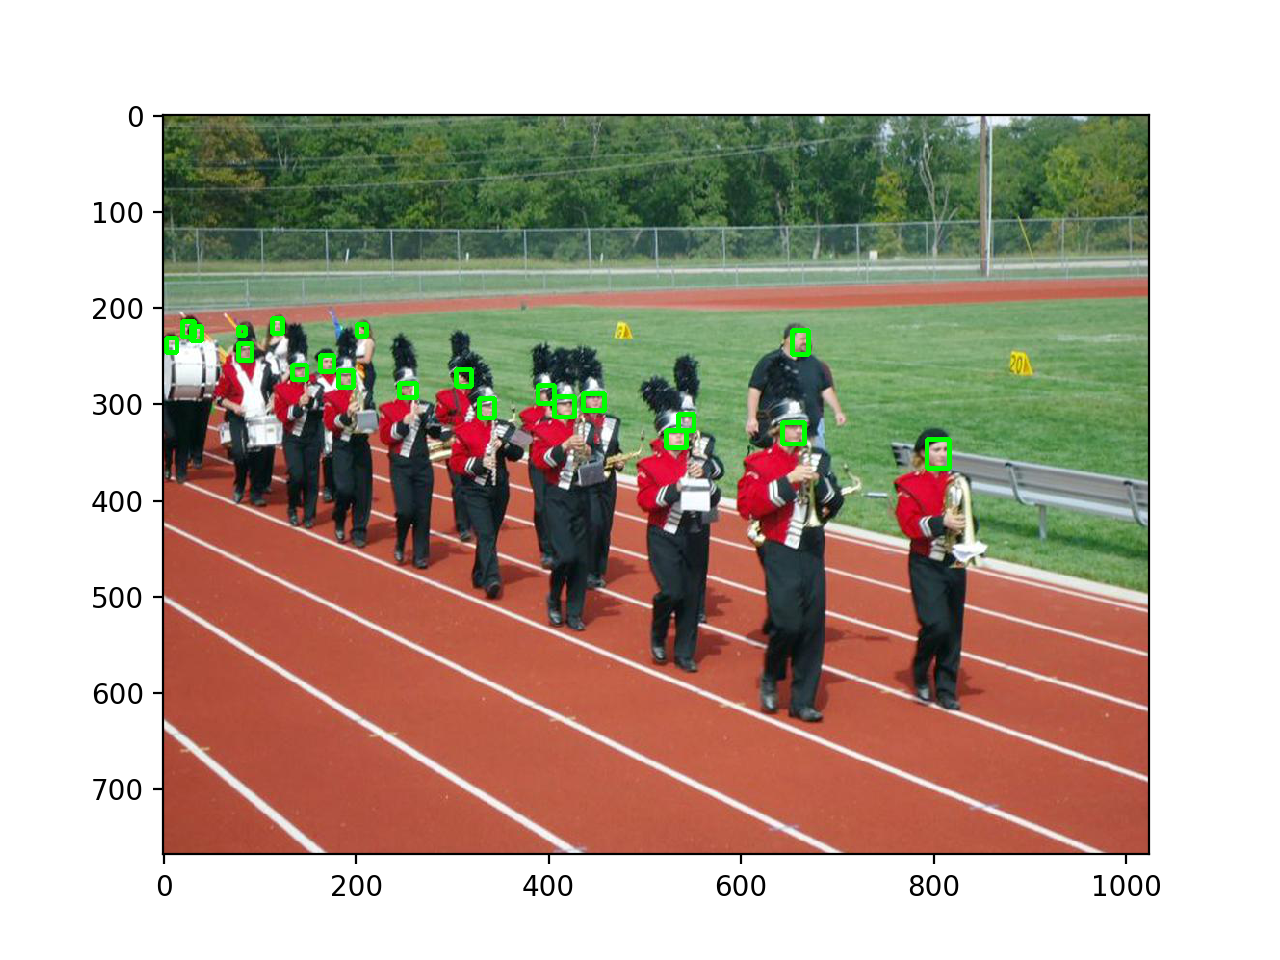

In [5]:
img = img_orig_1.copy()
h, w = dim_1
for box in boxes_1:
    cv2.rectangle(img, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), (0,255,0), 3)
plt.figure()
plt.imshow(img)
plt.show()

##### Compute bounding boxes from encoded & decoded values

<IPython.core.display.Javascript object>


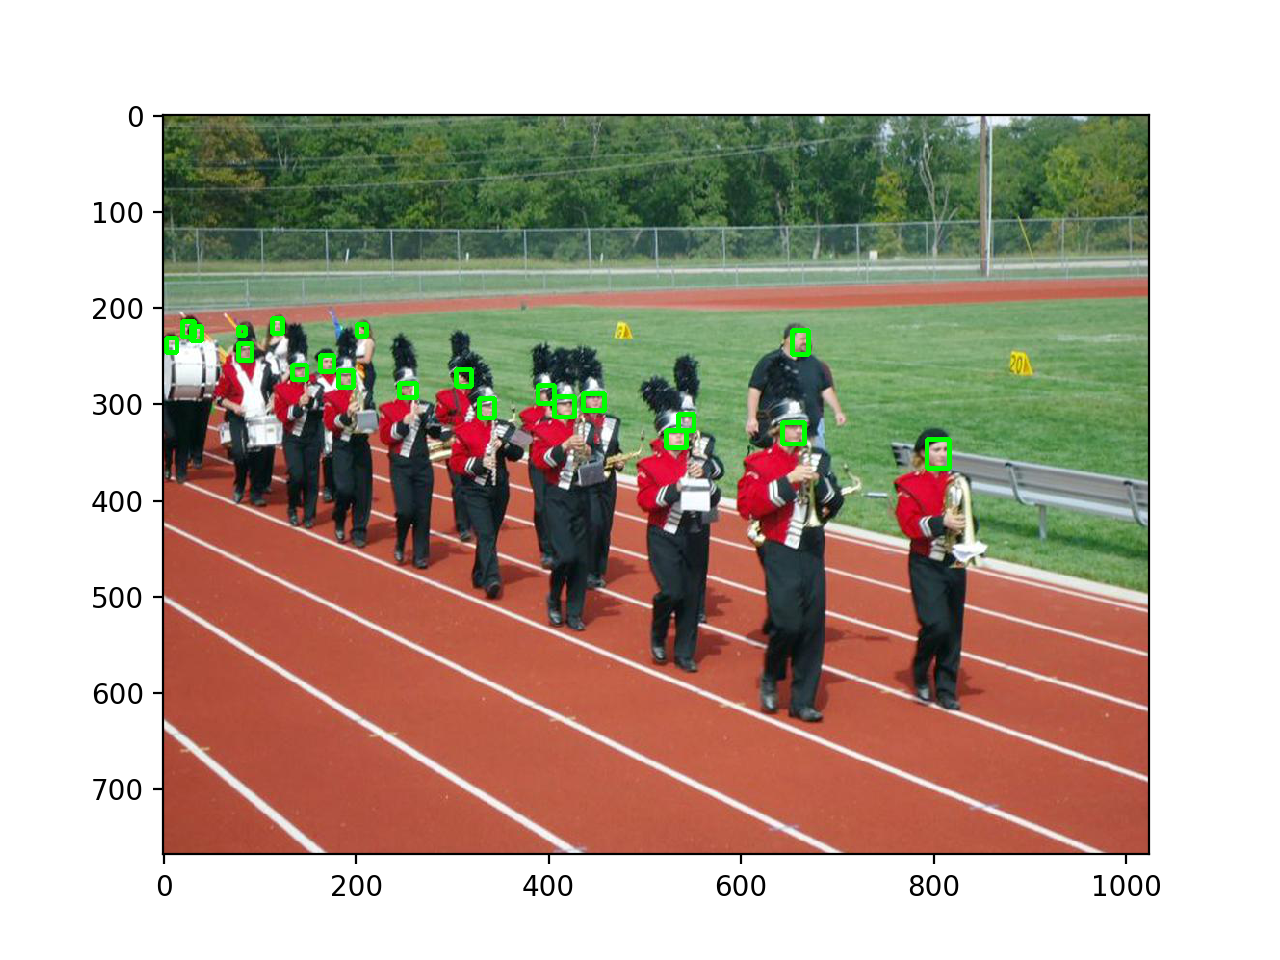

In [6]:
img = img_orig_1.copy()
h, w = dim_1
for box in boxes_preds:
    cv2.rectangle(img, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), (0,255,0), 3)
plt.figure()
plt.imshow(img)
plt.show()